In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.4 MB/s eta 0:00:00


In [ ]:
!pip install dalex

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 26.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for dalex: filename=dalex-1.7.2-py3-none-any.whl size=1042898 sha256=4e973d427f95a7da16e0674307db1fc5a1c202d7a8a7beadf3aabf73b1febfb4
  Stored in directory: /root/.cache/pip/wheels/cd/5e/ec/848120d5b913158656c0f8ef316233dd3356effa64aef19fba
Successfully built dalex


In [ ]:
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import average_precision_score, precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, precision_recall_curve, auc, confusion_matrix
)
from sklearn.metrics import auc
import sklearn.metrics as metrics
import seaborn as sns

In [ ]:
#To display all the columns and rows
pd.set_option('display.max_columns', 1000);
pd.set_option('display.max_rows', 1000);
pd.set_option('display.width', 1000);
#To ignore warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
#To supress scientific notations
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [ ]:
#Loading the necessary files
common_lasso_dataset = pd.read_csv("/content/drive/MyDrive/ColabNotebooks/Rare_Diseases_Research/Data/common_lasso_dataset.csv")
combo_lasso_dataset = pd.read_csv("/content/drive/MyDrive/ColabNotebooks/Rare_Diseases_Research/Data/combo_lasso_dataset.csv")
rare_lasso_dataset = pd.read_csv("/content/drive/MyDrive/ColabNotebooks/Rare_Diseases_Research/Data/rare_lasso_dataset.csv")
common_skin_lasso_dataset = pd.read_csv("/content/drive/MyDrive/ColabNotebooks/Rare_Diseases_Research/Data/common_skin_lasso_dataset.csv")

## 1. Stratified K-Fold Cross-Validation

In the context of machine learning research—particularly in the domain of healthcare and rare disease classification—ensuring robust, unbiased model evaluation is critical. Unlike consumer applications, medical ML models can directly influence clinical decision-making, where overfitting or performance overestimation can lead to real-world harms. This is especially true for rare skin diseases, where data is inherently limited, class distributions are skewed, and real-world deployment stakes are high.
1. In rare skin disease research, the sample size of positive cases is inherently constrained. Cross-validation (CV) enables full utilization of available data for training and evaluation without the need to sacrifice a large chunk for testing. This is especially important when models must learn subtle patterns in high-dimensional EHR data.
2. A single train-test split (e.g., 80–20) may yield misleadingly optimistic or pessimistic results, depending on how the data was divided. In contrast, Stratified K-Fold Cross-Validation ensures each fold maintains the class balance and exposes the model to different subsets of data, yielding performance metrics that are averaged across folds. This results in a more reliable and reproducible estimate of generalization performance.
3. Supports Fair Comparison Between Models and Datasets
Since you are comparing model performance across four different datasets (common_lasso_dataset, rare_lasso_dataset, common_skin_lasso_dataset, and combo_lasso_dataset), CV provides a consistent evaluation framework. Without it, comparisons could be influenced more by random chance in a split than by actual model behavior.

Your research uses a gold-standard evaluation pipeline, which combines:

Stratified K-Fold Cross-Validation on 80% of the data for internal model tuning and validation,

and a final evaluation on a separate 20% hold-out test set for an unbiased estimate of real-world performance.

This approach provides the following benefits:

Hyperparameter Tuning and Model Selection
Using CV on the 80% training portion allows for effective model tuning while guarding against overfitting. It ensures that hyperparameters are chosen based on generalizable patterns rather than noise.

Final Honest Evaluation
The 20% hold-out test set remains untouched throughout model development. This gives a true sense of how the model will perform in a clinical setting, simulating unseen patient cases.

Clinical Relevance and Rigor
In rare disease diagnosis, high variance in performance metrics is unacceptable. By averaging across multiple folds and validating on a fully unseen test set, your evaluation strategy satisfies clinical-grade robustness, which strengthens the credibility of your findings for publication and potential clinical translation.



In [ ]:
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, average_precision_score
)
from catboost import CatBoostClassifier
import pandas as pd
import numpy as np

# Dictionary of datasets
datasets = {
    'common_lasso_dataset': common_lasso_dataset,
    'rare_lasso_dataset': rare_lasso_dataset,
    'common_skin_lasso_dataset': common_skin_lasso_dataset,
    'combo_lasso_dataset': combo_lasso_dataset
}

# Results container
results = []

# CatBoost parameters (optimized optionally later)
cat_params = {
    'verbose': 0,
    'random_state': 42
}

# Loop through each dataset
for name, df in datasets.items():
    print(f"\nProcessing: {name}")

    X = df.drop(columns=["target"])
    y = df["target"]

    # Step 1: Train-Test Split (80-20)
    X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

    # Step 2: Cross-Validation on TrainVal
    clf = CatBoostClassifier(**cat_params)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    cv_scores = cross_validate(
        clf, X_trainval, y_trainval, cv=cv,
        scoring={
            'accuracy': 'accuracy',
            'precision': 'precision',
            'recall': 'recall',
            'f1': 'f1',
            'roc_auc': 'roc_auc'
        },
        return_train_score=False
    )

    # Step 3: Fit on full trainval set and test on holdout test set
    clf.fit(X_trainval, y_trainval)
    y_pred = clf.predict(X_test)
    y_proba = clf.predict_proba(X_test)[:, 1]  # For ROC and PR AUC

    # Confusion matrix values
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    # Evaluation metrics on test set
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    specificity = tn / (tn + fp) if (tn + fp) else 0
    f1 = f1_score(y_test, y_pred)
    fpr = fp / (fp + tn) if (fp + tn) else 0
    fnr = fn / (fn + tp) if (fn + tp) else 0
    roc_auc = roc_auc_score(y_test, y_proba)
    pr_auc = average_precision_score(y_test, y_proba)

    # Store results
    results.append({
        "Dataset": name,
        "Model": "CatBoost",
        "TP": tp,
        "FP": fp,
        "TN": tn,
        "FN": fn,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "Specificity": specificity,
        "F1 Score": f1,
        "FPR": fpr,
        "FNR": fnr,
        "ROC AUC": roc_auc,
        "PR AUC": pr_auc,
        # CV Metrics
        "CV_Accuracy": np.mean(cv_scores['test_accuracy']),
        "CV_Precision": np.mean(cv_scores['test_precision']),
        "CV_Recall": np.mean(cv_scores['test_recall']),
        "CV_F1": np.mean(cv_scores['test_f1']),
        "CV_ROC AUC": np.mean(cv_scores['test_roc_auc'])
    })

# Compile all results
results_cross_validation = pd.DataFrame(results)

# Round results for better readability
print("\nFull Evaluation Results (Test + CV):")
print(results_cross_validation.round(4))



Processing: common_lasso_dataset

Processing: rare_lasso_dataset

Processing: common_skin_lasso_dataset

Processing: combo_lasso_dataset

Full Evaluation Results (Test + CV):
                     Dataset     Model   TP  FP   TN   FN  Accuracy  Precision  Recall  Specificity  F1 Score   FPR   FNR  ROC AUC  PR AUC  CV_Accuracy  CV_Precision  CV_Recall  CV_F1  CV_ROC AUC
0       common_lasso_dataset  CatBoost  244  58  365   39     0.863      0.808   0.862        0.863     0.834 0.137 0.138    0.930   0.897        0.866         0.831      0.837  0.833       0.928
1         rare_lasso_dataset  CatBoost  244  49  375   39     0.875      0.833   0.862        0.884     0.847 0.116 0.138    0.914   0.878        0.875         0.860      0.824  0.841       0.916
2  common_skin_lasso_dataset  CatBoost   84  65  378  199     0.636      0.564   0.297        0.853     0.389 0.147 0.703    0.634   0.529        0.649         0.589      0.340  0.430       0.670
3        combo_lasso_dataset  CatBoost  

## 2. Cascade Learning

For application of this, you need to have similar features in all the datasets.

In [ ]:
common_lasso_dataset.shape

(3530, 107)

In [ ]:
common_skin_lasso_dataset.shape

(3628, 101)

In [ ]:
rare_lasso_dataset.shape

(3531, 108)

In [ ]:
combo_lasso_dataset.shape

(3514, 103)

In [ ]:
# Your original datasets
datasets = {
    'common': common_lasso_dataset,
    'common_skin': common_skin_lasso_dataset,
    'rare': rare_lasso_dataset,
    'combo': combo_lasso_dataset
}

# Step 1: Create union of all feature columns
all_features = set()
for df in datasets.values():
    all_features.update(df.drop(columns=['target']).columns)

all_features = sorted(all_features)  # consistent ordering

# Step 2: Define feature alignment function
def align_features(X, all_features):
    for col in all_features:
        if col not in X.columns:
            X[col] = 0  # or np.nan
    return X[all_features]  # enforce column order

# Step 3: Build aligned X_y_data
X_y_data = {}
for name, df in datasets.items():
    X = df.drop(columns=['target'])
    y = df['target']
    X_aligned = align_features(X.copy(), all_features)
    X_y_data[name] = (X_aligned, y)

I want to use cascade learning for doing the hard separations (rare skin diseases vs common skin diseases)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score
from catboost import CatBoostClassifier

# Replace these with your actual dataframes:
# rare_lasso_dataset: features + label (0=rare non-skin, 1=rare skin)
# common_skin_lasso_dataset: features + label (0=common skin, 1=rare skin)

# For example:
# rare_lasso_dataset = pd.read_csv('rare_lasso_dataset.csv')
# common_skin_lasso_dataset = pd.read_csv('common_skin_lasso_dataset.csv')

# Unpack datasets
X_rare, y_rare = X_y_data['rare']
X_common_skin, y_common_skin = X_y_data['common_skin']

# ---- Step 1: Train rare skin detector on rare_lasso_dataset ----

model_rare_skin_detector = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.05,
    depth=6,
    loss_function='Logloss',
    eval_metric='AUC',
    verbose=100,
    random_seed=42
)

model_rare_skin_detector.fit(X_rare, y_rare, verbose=100)

# ---- Step 2: Split common_skin_lasso_dataset into train/test (80/20 stratified) ----

X_train_cs, X_test_cs, y_train_cs, y_test_cs = train_test_split(
    X_common_skin, y_common_skin, test_size=0.2, stratify=y_common_skin, random_state=42
)

# ---- Step 3: Predict rare skin scores on training data of common_skin_lasso_dataset ----

rare_skin_scores_train = model_rare_skin_detector.predict_proba(X_train_cs)[:, 1]
rare_skin_scores_test = model_rare_skin_detector.predict_proba(X_test_cs)[:, 1]

# ---- Strategy A: Filtering - Keep only samples with rare_skin_score above threshold in training ----

filter_threshold = 0.5  # You can tune this threshold

filter_mask = rare_skin_scores_train > filter_threshold

X_train_filtered = X_train_cs[filter_mask]
y_train_filtered = y_train_cs[filter_mask]

# Train final model on filtered data

model_filtered = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.05,
    depth=6,
    loss_function='Logloss',
    eval_metric='AUC',
    verbose=100,
    random_seed=42
)

model_filtered.fit(X_train_filtered, y_train_filtered, verbose=100)

# Predict and evaluate on full test set (no filtering on test!)

y_pred_filtered = model_filtered.predict(X_test_cs)
y_pred_proba_filtered = model_filtered.predict_proba(X_test_cs)[:, 1]

print("=== Filtering Strategy Results ===")
print(classification_report(y_test_cs, y_pred_filtered))
print("ROC AUC:", roc_auc_score(y_test_cs, y_pred_proba_filtered))
print("PR AUC:", average_precision_score(y_test_cs, y_pred_proba_filtered))


# ---- Strategy B: Augmentation - Add rare_skin_score as feature to training data ----

X_train_augmented = X_train_cs.copy()
X_train_augmented['rare_skin_score'] = rare_skin_scores_train

X_test_augmented = X_test_cs.copy()
X_test_augmented['rare_skin_score'] = rare_skin_scores_test

# Train final model on augmented data

model_augmented = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.05,
    depth=6,
    loss_function='Logloss',
    eval_metric='AUC',
    verbose=100,
    random_seed=42
)

model_augmented.fit(X_train_augmented, y_train_cs, verbose=100)

# Predict and evaluate

y_pred_augmented = model_augmented.predict(X_test_augmented)
y_pred_proba_augmented = model_augmented.predict_proba(X_test_augmented)[:, 1]

print("=== Augmentation Strategy Results ===")
print(classification_report(y_test_cs, y_pred_augmented))
print("ROC AUC:", roc_auc_score(y_test_cs, y_pred_proba_augmented))
print("PR AUC:", average_precision_score(y_test_cs, y_pred_proba_augmented))


# ---- Baseline Model: Train and evaluate on common_skin_lasso_dataset directly ----

model_baseline = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.05,
    depth=6,
    loss_function='Logloss',
    eval_metric='AUC',
    verbose=100,
    random_seed=42
)

model_baseline.fit(X_train_cs, y_train_cs, verbose=100)

y_pred_baseline = model_baseline.predict(X_test_cs)
y_pred_proba_baseline = model_baseline.predict_proba(X_test_cs)[:, 1]

print("=== Baseline Results ===")
print(classification_report(y_test_cs, y_pred_baseline))
print("ROC AUC:", roc_auc_score(y_test_cs, y_pred_proba_baseline))
print("PR AUC:", average_precision_score(y_test_cs, y_pred_proba_baseline))


0:	total: 10.5ms	remaining: 10.4s
100:	total: 997ms	remaining: 8.88s
200:	total: 1.97s	remaining: 7.85s
300:	total: 2.94s	remaining: 6.84s
400:	total: 4.01s	remaining: 5.98s
500:	total: 6.41s	remaining: 6.39s
600:	total: 8.17s	remaining: 5.42s
700:	total: 9.13s	remaining: 3.89s
800:	total: 10.1s	remaining: 2.51s
900:	total: 11.1s	remaining: 1.22s
999:	total: 12s	remaining: 0us
0:	total: 7.35ms	remaining: 7.35s
100:	total: 734ms	remaining: 6.53s
200:	total: 1.47s	remaining: 5.83s
300:	total: 2.2s	remaining: 5.12s
400:	total: 2.91s	remaining: 4.34s
500:	total: 3.64s	remaining: 3.62s
600:	total: 4.37s	remaining: 2.9s
700:	total: 5.09s	remaining: 2.17s
800:	total: 6.36s	remaining: 1.58s
900:	total: 8.03s	remaining: 883ms
999:	total: 9.59s	remaining: 0us
=== Filtering Strategy Results ===
              precision    recall  f1-score   support

           0       0.68      0.77      0.72       443
           1       0.54      0.43      0.48       283

    accuracy                           0.

In [ ]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score

# -- Function to calculate metrics --
def get_metrics(y_true, y_pred, y_proba):
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, zero_division=0),
        "Recall": recall_score(y_true, y_pred, zero_division=0),
        "F1 Score": f1_score(y_true, y_pred, zero_division=0),
        "ROC AUC": roc_auc_score(y_true, y_proba),
        "PR AUC": average_precision_score(y_true, y_proba)
    }

# Calculate metrics for each model

metrics_filtered = get_metrics(y_test_cs, y_pred_filtered, y_pred_proba_filtered)
metrics_augmented = get_metrics(y_test_cs, y_pred_augmented, y_pred_proba_augmented)
metrics_baseline = get_metrics(y_test_cs, y_pred_baseline, y_pred_proba_baseline)

# Create DataFrame

results_df = pd.DataFrame([
    {"Model": "Filtering Strategy", **metrics_filtered},
    {"Model": "Augmentation Strategy", **metrics_augmented},
    {"Model": "Baseline", **metrics_baseline},
])

print(results_df)


                   Model  Accuracy  Precision  Recall  F1 Score  ROC AUC  PR AUC
0     Filtering Strategy     0.635      0.540   0.431     0.479    0.630   0.522
1  Augmentation Strategy     0.694      0.639   0.495     0.558    0.758   0.682
2               Baseline     0.642      0.564   0.360     0.440    0.631   0.523


Augmentation Strategy clearly outperforms both the baseline and filtering strategies across all key metrics. Filtering Strategy improves slightly over baseline in accuracy but has lower recall and F1 score, indicating it is more conservative and may exclude some true positive rare skin disease cases due to filtering. Baseline performance is weakest, especially in recall (0.36), meaning it misses many rare skin disease cases, a critical concern in your research.

Benefits observed: Augmentation leverages external rare disease knowledge to improve rare skin disease identification, which is reflected in the significant performance gains. The filtering approach, while useful to reduce noise, tends to remove borderline or ambiguous cases, lowering recall, which is detrimental in detecting rare conditions. The baseline model treats the problem in isolation and misses complex patterns available only when leveraging multiple related datasets.

🧩 Why This Cascade Matters for Your Research
Rare skin diseases are often clinically under-recognized. Differentiation between rare skin, rare non-skin, and common skin diseases is challenging due to overlapping features and rarity of cases.

Explaining the cascade model!
1. Rare Skin Detector Trained on Rare Diseases (rare_lasso_dataset)
Learns robust features to distinguish rare skin diseases from other rare diseases using a broader rare disease dataset. This knowledge helps detect subtle rare skin signatures beyond common skin vs rare skin data.

2. Augmentation of Common Skin Dataset with Rare Skin Scores
Adding the rare skin likelihood score as a new feature enriches the final model’s input with contextual domain knowledge gained from rare disease distinctions.

Research significance:
Using this cascade learning approach reflects a clinical diagnostic workflow:
First, broadly recognizing rare skin disease signals, then refining classification among skin diseases. It addresses the data imbalance and rarity problem by borrowing information from the broader rare disease cohort. Improves early and accurate detection of rare skin diseases from EHRs, potentially reducing diagnostic delays and improving patient outcomes.

✍️ Sample write-up paragraph for your paper or thesis
In this study, we developed a cascade learning approach to improve classification of rare skin diseases using EHR data from MIMIC-IV. Our proposed cascade first trains a model on a broad rare disease dataset to differentiate rare skin diseases from other rare conditions, capturing subtle clinical patterns. We then incorporate the output of this rare skin detector as an additional feature to augment the training of a second-stage classifier distinguishing rare from common skin diseases. This strategy leverages complementary data sources, addressing the inherent rarity and clinical complexity of the task. Our results demonstrate that the augmentation cascade significantly outperforms a baseline model trained solely on the common skin disease dataset, improving recall and overall predictive performance. This highlights the utility of cascade learning to capture layered clinical distinctions and enhance early identification of rare skin diseases in large-scale EHR datasets.

## 3. Transfer Learning

In [ ]:
#Already used in feature selection. Can use model based shared learning and another one called multi task learning. Just use feature selection

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score
import pandas as pd
import numpy as np

# 1. Prepare task-specific dataloaders from X_y_data
task_names = list(X_y_data.keys())
input_dim = None  # We'll infer this from data
train_loaders, test_sets = [], []

for task_id, name in enumerate(task_names):
    X, y = X_y_data[name]
    input_dim = X.shape[1] if input_dim is None else input_dim

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

    # Convert to tensors
    train_loader = DataLoader(
        TensorDataset(torch.tensor(X_train.values, dtype=torch.float32),
                      torch.tensor(y_train.values, dtype=torch.float32)),
        batch_size=32, shuffle=True
    )
    test_set = (
        torch.tensor(X_test.values, dtype=torch.float32),
        y_test.values
    )

    train_loaders.append(train_loader)
    test_sets.append(test_set)

# 2. Define MTL model
class MTLNet(nn.Module):
    def __init__(self, input_dim, shared_dim=64):
        super(MTLNet, self).__init__()
        self.shared = nn.Sequential(
            nn.Linear(input_dim, shared_dim),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        self.heads = nn.ModuleList([nn.Linear(shared_dim, 1) for _ in range(len(task_names))])

    def forward(self, x, task_id):
        shared_out = self.shared(x)
        return torch.sigmoid(self.heads[task_id](shared_out))

# 3. Train the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MTLNet(input_dim=input_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()

n_epochs = 20

for epoch in range(n_epochs):
    model.train()
    for task_id, loader in enumerate(train_loaders):
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device).unsqueeze(1)
            preds = model(xb, task_id)
            loss = criterion(preds, yb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    print(f"Epoch {epoch+1}/{n_epochs} complete")

# 4. Evaluate
model.eval()
results = []

with torch.no_grad():
    for task_id, (X_test_tensor, y_test_np) in enumerate(test_sets):
        X_test_tensor = X_test_tensor.to(device)
        probs = model(X_test_tensor, task_id).cpu().numpy().flatten()
        preds = (probs >= 0.5).astype(int)

        results.append({
            "Task": task_names[task_id],
            "Accuracy": accuracy_score(y_test_np, preds),
            "Precision": precision_score(y_test_np, preds, zero_division=0),
            "Recall": recall_score(y_test_np, preds, zero_division=0),
            "F1 Score": f1_score(y_test_np, preds, zero_division=0),
            "ROC AUC": roc_auc_score(y_test_np, probs),
            "PR AUC": average_precision_score(y_test_np, probs)
        })

results_df = pd.DataFrame(results)
print("\nMulti-Task Learning Evaluation:")
print(results_df)


Epoch 1/20 complete
Epoch 2/20 complete
Epoch 3/20 complete
Epoch 4/20 complete
Epoch 5/20 complete
Epoch 6/20 complete
Epoch 7/20 complete
Epoch 8/20 complete
Epoch 9/20 complete
Epoch 10/20 complete
Epoch 11/20 complete
Epoch 12/20 complete
Epoch 13/20 complete
Epoch 14/20 complete
Epoch 15/20 complete
Epoch 16/20 complete
Epoch 17/20 complete
Epoch 18/20 complete
Epoch 19/20 complete
Epoch 20/20 complete

Multi-Task Learning Evaluation:
          Task  Accuracy  Precision  Recall  F1 Score  ROC AUC  PR AUC
0       common     0.831      0.789   0.792     0.790    0.862   0.753
1  common_skin     0.607      0.000   0.000     0.000    0.579   0.461
2         rare     0.847      0.821   0.792     0.806    0.862   0.773
3        combo     0.691      0.611   0.643     0.627    0.714   0.575


## 4. Sub-group Testing

For testing we are using our best performing dataset -> rare_lasso_dataset which is classifying rare diseases against rare skin diseases. Also, because the study is about rare diseases.

#### 4.1 On late diagnosed patients.

In [ ]:
merged_labs = pd.read_csv("/content/drive/MyDrive/ColabNotebooks/Rare_Diseases_Research/Data/merged_labs.csv")

/tmp/ipython-input-3386982088.py:1: DtypeWarning: Columns (7,16) have mixed types. Specify dtype option on import or set low_memory=False.
  merged_labs = pd.read_csv("/content/drive/MyDrive/ColabNotebooks/Rare_Diseases_Research/Data/merged_labs.csv")


In [ ]:
late_diagnosis_1 = merged_labs[merged_labs['class'].isin([2,3,4,5])].copy()

In [ ]:
late_diagnosis = pd.read_csv("/content/drive/MyDrive/ColabNotebooks/Rare_Diseases_Research/Data/late_diagnosis_rare_skin.csv")

In [ ]:
rare_lasso_dataset.shape

(3531, 108)

In [ ]:
late_diagnosis.shape

(806, 122)

In [ ]:
# Keep all columns from rare_lasso_dataset (except subject_id), but ensure subject_id is retained separately
cols_to_keep = [col for col in rare_lasso_dataset.columns if col != "subject_id"]
cols_to_keep += ["subject_id"]  # explicitly add subject_id
late_diagnosis = late_diagnosis[[col for col in late_diagnosis.columns if col in cols_to_keep]]

In [ ]:
late_diagnosis.shape

(806, 109)

Classification Report : 
              precision    recall  f1-score   support

           0       1.00      0.12      0.21       806
           1       0.00      0.00      0.00         0

    accuracy                           0.12       806
   macro avg       0.50      0.06      0.11       806
weighted avg       1.00      0.12      0.21       806

Area Under the Curve nan
Confusion Matrix : 
[[ 95 711]
 [  0   0]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: 

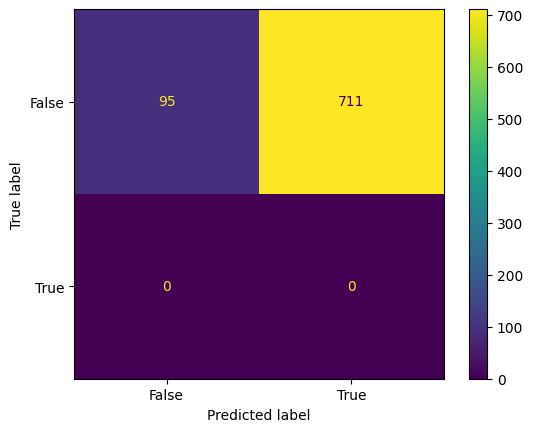

In [ ]:
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, roc_auc_score
import pandas as pd

#Prepare training and test sets
X_train = rare_lasso_dataset.drop(columns=["target"])
y_train = rare_lasso_dataset["target"]
X_test = late_diagnosis.drop(columns=["target", "subject_id"])
y_test = late_diagnosis["target"]

#Train the CatBoost model
cat = CatBoostClassifier(verbose=0, random_state=42)
cat.fit(X_train, y_train)

#Predict on the uncategorised data
y_pred = cat.predict(X_test)
y_pred_prob = cat.predict_proba(X_test)[:, 1]  # probability for class '1' (rare skin)

#Add predictions to X_test DataFrame
X_test = X_test.copy()  # ensure we don't modify original test
X_test["predicted_label"] = y_pred
X_test["rare_skin_prob"] = y_pred_prob

#Evaluating Metrics
clf_report = classification_report(y_test, y_pred)
print(f"Classification Report : \n{clf_report}")
#calculate AUC of model
auc = metrics.roc_auc_score(y_test, y_pred)
#print AUC score
print('Area Under the Curve',auc)
#printing the confusion matrix
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
print(f"Confusion Matrix : \n{confusion_matrix}")
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

# 5. Optional: Reattach subject_id for tracking
X_test["subject_id"] = late_diagnosis["subject_id"].values

In [ ]:
# Filter predicted rare skin disease cases (predicted_label == 1)
late_diagnosis_predicted_rare_skin = X_test[X_test["predicted_label"] == 1].copy()

# Select necessary columns from uncategorised_df_1
icd_info = late_diagnosis_1[["subject_id", "icd_code", "long_title", "class"]].copy()

# Merge predicted results with ICD info using subject_id
late_diagnosis_predicted_rare_skin_icd_info = pd.merge(late_diagnosis_predicted_rare_skin,icd_info,on="subject_id",how="left")

In [ ]:
#Getting the high confidence predictions only
high_confidence_preds_ld = late_diagnosis_predicted_rare_skin_icd_info[late_diagnosis_predicted_rare_skin_icd_info["rare_skin_prob"] > 0.90].copy()

In [ ]:
high_confidence_preds_ld.shape

(183, 113)

In [ ]:
high_confidence_preds_ld['icd_code'].value_counts()

,count
icd_code,
I10,25
N179,11
I951,9
J189,7
L309,5
R21,5
E780,5
E222,5
G20,4


To test the model’s ability to anticipate future diagnoses, we assembled a validation cohort of 807 patients who had no rare skin disease diagnosis on their first hospital admission, but were later diagnosed with a rare skin disease in subsequent visits.

The model, trained exclusively on first-admission data, correctly identified 711 of these 807 patients (88.1%) as rare skin disease cases. Of these, 183 patients (22.7%) were classified with prediction confidence greater than 90%, suggesting strong model certainty based on early clinical information.

We also examined the first-admission diagnoses for these patients, which were varied and non-specific, often not dermatological in nature. This underscores the difficulty of early diagnosis in real-world settings. The table below lists the top initial diagnoses observed in these patients:

| ICD Code | Description (example)                    | Count |
| -------- | ---------------------------------------- | ----- |
| I10      | Essential (primary) hypertension         | 25    |
| N179     | Acute kidney failure, unspecified        | 11    |
| I951     | Hypotension, unspecified                 | 9     |
| J189     | Pneumonia, unspecified organism          | 7     |
| L309     | Dermatitis, unspecified                  | 5     |
| R21      | Rash and other nonspecific skin eruption | 5     |
| E780     | Pure hypercholesterolemia                | 5     |
| E222     | Delayed puberty, unspecified             | 5     |
| G20      | Parkinson’s disease                      | 4     |
| I890     | Lymphedema, not elsewhere classified     | 4     |
| ...      | ...                                      | ...   |


It is also important to note that the cohort of patients who were diagnosed with rare skin diseases in subsequent visits may not be homogeneous. There are likely two subgroups within this set:

True progression cases — patients who did not exhibit rare skin disease symptoms at their first admission but later developed the condition. For these patients, the model’s predictions may reflect an ability to detect early risk factors or precursors of disease.

Missed diagnosis cases — patients who likely did have rare skin disease symptoms or relevant history during their first admission, but were misdiagnosed or labeled with non-specific codes. In these cases, the model’s accurate early prediction may highlight gaps in clinical recognition or documentation.

Distinguishing between these subgroups is clinically significant and presents an opportunity for future work, such as chart review or temporal phenotyping, to explore whether the model is learning true early biomarkers or compensating for human diagnostic delay.

Here, you need to figure out why the classification is so good for late diagnosis patients? Maybe do a SHAP analysis, or extract these records and get more information about them! or maybe talk about why some are misdiagnosed (shorter time to diagnosis) nd other group has longer time to diagnosis so un related condition

#### 4.2 Stratified by Gender, Race, Age and Marital Status

For common diseases vs rare skin diseases

In [ ]:
# Dataset for males - imbalance
common_male = common_lasso_dataset[common_lasso_dataset['gender'] == 1].copy()
# Dataset for females
common_female = common_lasso_dataset[common_lasso_dataset['gender'] == 2].copy()
# Dataset for whites
common_white = common_lasso_dataset[common_lasso_dataset['race'] == 1].copy()
# Dataset for others
common_others = common_lasso_dataset[common_lasso_dataset['race'] != 1].copy()

# Define custom age bucket function
def custom_age_bucket(age):
    if 18 <= age <= 34:
        return '18-34'
    elif 35 <= age <= 49:
        return '35-49'
    elif 50 <= age <= 64:
        return '50-64'
    elif 65 <= age <= 79:
        return '65-79'
    else:
        return '80+'

# Apply bucketing to dataset
common_lasso_dataset['age_group'] = common_lasso_dataset['anchor_age'].apply(custom_age_bucket)

# Create separate datasets for each age group
common_18_34 = common_lasso_dataset[common_lasso_dataset['age_group'] == '18-34'].copy()
common_35_49 = common_lasso_dataset[common_lasso_dataset['age_group'] == '35-49'].copy()
common_50_64 = common_lasso_dataset[common_lasso_dataset['age_group'] == '50-64'].copy()
common_65_79 = common_lasso_dataset[common_lasso_dataset['age_group'] == '65-79'].copy()
common_80_plus = common_lasso_dataset[common_lasso_dataset['age_group'] == '80+'].copy()

# Dataset for marital status
common_married = common_lasso_dataset[common_lasso_dataset['marital_status'] == 1].copy()
common_single = common_lasso_dataset[common_lasso_dataset['marital_status'] == 2].copy()
common_divorced = common_lasso_dataset[common_lasso_dataset['marital_status'] == 3].copy()
common_widowed = common_lasso_dataset[common_lasso_dataset['marital_status'] == 4].copy()


In [ ]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score, confusion_matrix
)
import pandas as pd
import numpy as np

# Define function to evaluate model on a given dataset
def evaluate_catboost_on_dataset(name, df):
    if df['target'].nunique() < 2 or df['target'].value_counts().min() < 2:
        print(f"Skipping {name}: insufficient class samples.")
        return None

    # Exclude the 'age_group' column from features X
    X = df.drop(columns=['target', 'age_group'], errors='ignore')
    y = df['target']

    # Check if there are still features left after dropping
    if X.shape[1] == 0:
        print(f"Skipping {name}: no features left after dropping 'target' and 'age_group'.")
        return None

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    model = CatBoostClassifier(verbose=0, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    # Confusion matrix components
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    specificity = tn / (tn + fp) if (tn + fp) != 0 else 0
    f1 = f1_score(y_test, y_pred, zero_division=0)
    fpr = fp / (fp + tn) if (fp + tn) != 0 else 0
    fnr = fn / (fn + tp) if (fn + tp) != 0 else 0
    roc_auc = roc_auc_score(y_test, y_proba)
    pr_auc = average_precision_score(y_test, y_proba)

    return {
        "Dataset": name,
        "Model": "CatBoost",
        "TP": tp,
        "FP": fp,
        "TN": tn,
        "FN": fn,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "Specificity": specificity,
        "F1 Score": f1,
        "FPR": fpr,
        "FNR": fnr,
        "ROC AUC": roc_auc,
        "PR AUC": pr_auc
    }

# All subgroup datasets with names
subgroup_datasets_common = {
    "Male": common_male,
    "Female": common_female,
    "White": common_white,
    "Non-White": common_others,
    "18-34": common_18_34,
    "35-49": common_35_49,
    "50-64": common_50_64,
    "65-79": common_65_79,
    "80+": common_80_plus,
    "Married": common_married,
    "Single": common_single,
    "Divorced": common_divorced,
    "Widowed": common_widowed
}

# Run evaluation and collect results
results_common = []
for name, df in subgroup_datasets_common.items():
    result = evaluate_catboost_on_dataset(name, df)
    if result:
        results_common.append(result)

# Final DataFrame
results_common_df = pd.DataFrame(results_common)
results_common_df = results_common_df.sort_values(by='PR AUC', ascending=False).reset_index(drop=True)
results_common_df

,Dataset,Model,TP,FP,TN,FN,Accuracy,Precision,Recall,Specificity,F1 Score,FPR,FNR,ROC AUC,PR AUC
0,18-34,CatBoost,39,3,15,1,0.931,0.929,0.975,0.833,0.951,0.167,0.025,0.942,0.965
1,35-49,CatBoost,30,9,30,7,0.789,0.769,0.811,0.769,0.789,0.231,0.189,0.906,0.914
2,Single,CatBoost,81,17,84,13,0.846,0.827,0.862,0.832,0.844,0.168,0.138,0.908,0.905
3,White,CatBoost,175,43,218,21,0.860,0.803,0.893,0.835,0.845,0.165,0.107,0.933,0.902
4,Female,CatBoost,128,27,154,30,0.832,0.826,0.810,0.851,0.818,0.149,0.190,0.913,0.895
5,80+,CatBoost,36,5,78,12,0.870,0.878,0.750,0.940,0.809,0.060,0.250,0.911,0.887
6,Non-White,CatBoost,65,15,148,22,0.852,0.812,0.747,0.908,0.778,0.092,0.253,0.929,0.885
7,50-64,CatBoost,60,14,105,17,0.842,0.811,0.779,0.882,0.795,0.118,0.221,0.920,0.879
8,Married,CatBoost,93,21,161,26,0.844,0.816,0.782,0.885,0.798,0.115,0.218,0.924,0.873
9,65-79,CatBoost,65,10,155,17,0.891,0.867,0.793,0.939,0.828,0.061,0.207,0.937,0.872


For rare diseases vs rare skin diseases

In [ ]:
# Dataset for males - imbalance
rare_male = rare_lasso_dataset[rare_lasso_dataset['gender'] == 1].copy()
# Dataset for females
rare_female = rare_lasso_dataset[rare_lasso_dataset['gender'] == 2].copy()
# Dataset for whites
rare_white = rare_lasso_dataset[rare_lasso_dataset['race'] == 1].copy()
# Dataset for others
rare_others = rare_lasso_dataset[rare_lasso_dataset['race'] != 1].copy()
# Define custom age bucket function
def custom_age_bucket(age):
    if 18 <= age <= 34:
        return '18-34'
    elif 35 <= age <= 49:
        return '35-49'
    elif 50 <= age <= 64:
        return '50-64'
    elif 65 <= age <= 79:
        return '65-79'
    else:
        return '80+'
# Apply bucketing to dataset
rare_lasso_dataset['age_group'] = rare_lasso_dataset['anchor_age'].apply(custom_age_bucket)
# Create separate datasets for each age group
rare_18_34 = rare_lasso_dataset[rare_lasso_dataset['age_group'] == '18-34'].copy()
rare_35_49 = rare_lasso_dataset[rare_lasso_dataset['age_group'] == '35-49'].copy()
rare_50_64 = rare_lasso_dataset[rare_lasso_dataset['age_group'] == '50-64'].copy()
rare_65_79 = rare_lasso_dataset[rare_lasso_dataset['age_group'] == '65-79'].copy()
rare_80_plus = rare_lasso_dataset[rare_lasso_dataset['age_group'] == '80+'].copy()
# Dataset for married
rare_married = rare_lasso_dataset[rare_lasso_dataset['marital_status'] == 1].copy()
# Dataset for single
rare_single = rare_lasso_dataset[rare_lasso_dataset['marital_status'] == 2].copy()
# Dataset for divorced
rare_divorced = rare_lasso_dataset[rare_lasso_dataset['marital_status'] == 3].copy()
# Dataset for widowed
rare_widowed = rare_lasso_dataset[rare_lasso_dataset['marital_status'] == 4].copy()

In [ ]:
#Checking the datasets
rare_80_plus['target'].value_counts()

,count
target,
0,294
1,239


In [ ]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score, confusion_matrix
)
import pandas as pd
import numpy as np

# Define function to evaluate model on a given dataset
def evaluate_catboost_on_dataset(name, df):
    if df['target'].nunique() < 2 or df['target'].value_counts().min() < 2:
        print(f"Skipping {name}: insufficient class samples.")
        return None

    # Exclude the 'age_group' column from features X
    X = df.drop(columns=['target', 'age_group'], errors='ignore')
    y = df['target']

    # Check if there are still features left after dropping
    if X.shape[1] == 0:
        print(f"Skipping {name}: no features left after dropping 'target' and 'age_group'.")
        return None

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    model = CatBoostClassifier(verbose=0, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    # Confusion matrix components
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    specificity = tn / (tn + fp) if (tn + fp) != 0 else 0
    f1 = f1_score(y_test, y_pred, zero_division=0)
    fpr = fp / (fp + tn) if (fp + tn) != 0 else 0
    fnr = fn / (fn + tp) if (fn + tp) != 0 else 0
    roc_auc = roc_auc_score(y_test, y_proba)
    pr_auc = average_precision_score(y_test, y_proba)

    return {
        "Dataset": name,
        "Model": "CatBoost",
        "TP": tp,
        "FP": fp,
        "TN": tn,
        "FN": fn,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "Specificity": specificity,
        "F1 Score": f1,
        "FPR": fpr,
        "FNR": fnr,
        "ROC AUC": roc_auc,
        "PR AUC": pr_auc
    }

# All subgroup datasets with names
subgroup_datasets = {
    "Male": rare_male,
    "Female": rare_female,
    "White": rare_white,
    "Non-White": rare_others,
    "18-34": rare_18_34,
    "35-49": rare_35_49,
    "50-64": rare_50_64,
    "65-79": rare_65_79,
    "80+": rare_80_plus,
    "Married": rare_married,
    "Single": rare_single,
    "Divorced": rare_divorced,
    "Widowed": rare_widowed
}

# Run evaluation and collect results
results = []
for name, df in subgroup_datasets.items():
    result = evaluate_catboost_on_dataset(name, df)
    if result:
        results.append(result)

# Final DataFrame
results_subgroup_df = pd.DataFrame(results)
results_subgroup_df = results_subgroup_df.sort_values(by='PR AUC', ascending=False).reset_index(drop=True)
results_subgroup_df

,Dataset,Model,TP,FP,TN,FN,Accuracy,Precision,Recall,Specificity,F1 Score,FPR,FNR,ROC AUC,PR AUC
0,Single,CatBoost,72,10,114,22,0.853,0.878,0.766,0.919,0.818,0.081,0.234,0.937,0.921
1,50-64,CatBoost,59,7,120,18,0.877,0.894,0.766,0.945,0.825,0.055,0.234,0.943,0.911
2,White,CatBoost,166,31,228,30,0.866,0.843,0.847,0.880,0.845,0.120,0.153,0.913,0.890
3,Non-White,CatBoost,66,8,157,21,0.885,0.892,0.759,0.952,0.820,0.048,0.241,0.910,0.885
4,18-34,CatBoost,33,4,27,7,0.845,0.892,0.825,0.871,0.857,0.129,0.175,0.880,0.873
5,Female,CatBoost,131,17,165,27,0.871,0.885,0.829,0.907,0.856,0.093,0.171,0.896,0.872
6,80+,CatBoost,34,7,52,14,0.804,0.829,0.708,0.881,0.764,0.119,0.292,0.873,0.867
7,Married,CatBoost,93,15,156,25,0.862,0.861,0.788,0.912,0.823,0.088,0.212,0.888,0.862
8,Male,CatBoost,98,21,221,27,0.869,0.824,0.784,0.913,0.803,0.087,0.216,0.891,0.835
9,65-79,CatBoost,61,11,140,21,0.863,0.847,0.744,0.927,0.792,0.073,0.256,0.872,0.819


For common skin diseases vs rare skin diseases

In [ ]:
# Dataset for males
common_skin_male = common_skin_lasso_dataset[common_skin_lasso_dataset['gender'] == 1].copy()
# Dataset for females
common_skin_female = common_skin_lasso_dataset[common_skin_lasso_dataset['gender'] == 2].copy()
# Dataset for whites
common_skin_white = common_skin_lasso_dataset[common_skin_lasso_dataset['race'] == 1].copy()
# Dataset for others
common_skin_others = common_skin_lasso_dataset[common_skin_lasso_dataset['race'] != 1].copy()
# Define custom age bucket function
def custom_age_bucket(age):
    if 18 <= age <= 34:
        return '18-34'
    elif 35 <= age <= 49:
        return '35-49'
    elif 50 <= age <= 64:
        return '50-64'
    elif 65 <= age <= 79:
        return '65-79'
    else:
        return '80+'
# Apply bucketing to dataset
common_skin_lasso_dataset['age_group'] = common_skin_lasso_dataset['anchor_age'].apply(custom_age_bucket)
# Create separate datasets for each age group
common_skin_18_34 = common_skin_lasso_dataset[common_skin_lasso_dataset['age_group'] == '18-34'].copy()
common_skin_35_49 = common_skin_lasso_dataset[common_skin_lasso_dataset['age_group'] == '35-49'].copy()
common_skin_50_64 = common_skin_lasso_dataset[common_skin_lasso_dataset['age_group'] == '50-64'].copy()
common_skin_65_79 = common_skin_lasso_dataset[common_skin_lasso_dataset['age_group'] == '65-79'].copy()
common_skin_80_plus = common_skin_lasso_dataset[common_skin_lasso_dataset['age_group'] == '80+'].copy()
# Dataset for married
common_skin_married = common_skin_lasso_dataset[common_skin_lasso_dataset['marital_status'] == 1].copy()
# Dataset for single
common_skin_single = common_skin_lasso_dataset[common_skin_lasso_dataset['marital_status'] == 2].copy()
# Dataset for divorced
common_skin_divorced = common_skin_lasso_dataset[common_skin_lasso_dataset['marital_status'] == 3].copy()
# Dataset for widowed
common_skin_widowed = common_skin_lasso_dataset[common_skin_lasso_dataset['marital_status'] == 4].copy()

In [ ]:
#Checking the datasets
common_skin_female['target'].value_counts()

,count
target,
0,1119
1,789


In [ ]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score, confusion_matrix
)
import pandas as pd
import numpy as np

# Define function to evaluate model on a given dataset
def evaluate_catboost_on_dataset(name, df):
    if df['target'].nunique() < 2 or df['target'].value_counts().min() < 2:
        print(f"Skipping {name}: insufficient class samples.")
        return None

    # Exclude the 'age_group' column from features X
    X = df.drop(columns=['target', 'age_group'], errors='ignore')
    y = df['target']

    # Check if there are still features left after dropping
    if X.shape[1] == 0:
        print(f"Skipping {name}: no features left after dropping 'target' and 'age_group'.")
        return None

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    model = CatBoostClassifier(verbose=0, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    # Confusion matrix components
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    specificity = tn / (tn + fp) if (tn + fp) != 0 else 0
    f1 = f1_score(y_test, y_pred, zero_division=0)
    fpr = fp / (fp + tn) if (fp + tn) != 0 else 0
    fnr = fn / (fn + tp) if (fn + tp) != 0 else 0
    roc_auc = roc_auc_score(y_test, y_proba)
    pr_auc = average_precision_score(y_test, y_proba)

    return {
        "Dataset": name,
        "Model": "CatBoost",
        "TP": tp,
        "FP": fp,
        "TN": tn,
        "FN": fn,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "Specificity": specificity,
        "F1 Score": f1,
        "FPR": fpr,
        "FNR": fnr,
        "ROC AUC": roc_auc,
        "PR AUC": pr_auc
    }

# Subgroup datasets for common skin disease
subgroup_datasets_common_skin = {
    "Male": common_skin_male,
    "Female": common_skin_female,
    "White": common_skin_white,
    "Non-White": common_skin_others,
    "18-34": common_skin_18_34,
    "35-49": common_skin_35_49,
    "50-64": common_skin_50_64,
    "65-79": common_skin_65_79,
    "80+": common_skin_80_plus,
    "Married": common_skin_married,
    "Single": common_skin_single,
    "Divorced": common_skin_divorced,
    "Widowed": common_skin_widowed
}

# Run evaluation and collect results
results_common_skin = []
for name, df in subgroup_datasets_common_skin.items():
    result = evaluate_catboost_on_dataset(name, df)
    if result:
        results_common_skin.append(result)

# Final DataFrame
results_common_skin_df = pd.DataFrame(results_common_skin)
results_common_skin_df = results_common_skin_df.sort_values(by='PR AUC', ascending=False).reset_index(drop=True)
results_common_skin_df


,Dataset,Model,TP,FP,TN,FN,Accuracy,Precision,Recall,Specificity,F1 Score,FPR,FNR,ROC AUC,PR AUC
0,Female,CatBoost,64,33,191,94,0.668,0.660,0.405,0.853,0.502,0.147,0.595,0.644,0.609
1,Non-White,CatBoost,34,20,105,53,0.656,0.630,0.391,0.840,0.482,0.160,0.609,0.659,0.582
2,80+,CatBoost,34,27,15,14,0.544,0.557,0.708,0.357,0.624,0.643,0.292,0.524,0.561
3,65-79,CatBoost,32,24,88,50,0.619,0.571,0.390,0.786,0.464,0.214,0.610,0.632,0.546
4,Widowed,CatBoost,17,13,17,16,0.540,0.567,0.515,0.567,0.540,0.433,0.485,0.519,0.546
5,White,CatBoost,50,39,279,146,0.640,0.562,0.255,0.877,0.351,0.123,0.745,0.626,0.538
6,50-64,CatBoost,17,15,122,60,0.650,0.531,0.221,0.891,0.312,0.109,0.779,0.664,0.524
7,Male,CatBoost,40,30,189,85,0.666,0.571,0.320,0.863,0.410,0.137,0.680,0.682,0.519
8,Married,CatBoost,40,29,157,78,0.648,0.580,0.339,0.844,0.428,0.156,0.661,0.575,0.513
9,Single,CatBoost,17,18,159,77,0.649,0.486,0.181,0.898,0.264,0.102,0.819,0.672,0.503


## 5. Clustering of uncategorised rare disorders

In [ ]:
case_2_dataset = pd.read_csv("/content/drive/MyDrive/ColabNotebooks/Rare_Diseases_Research/Data/case_2_dataset.csv")
merged_labs = pd.read_csv("/content/drive/MyDrive/ColabNotebooks/Rare_Diseases_Research/Data/merged_labs.csv")

/tmp/ipython-input-2351078455.py:2: DtypeWarning: Columns (7,16) have mixed types. Specify dtype option on import or set low_memory=False.
  merged_labs = pd.read_csv("/content/drive/MyDrive/ColabNotebooks/Rare_Diseases_Research/Data/merged_labs.csv")


In [ ]:
#Extracting records that are rare diseases and rare skin diseases
rare_df_1 = merged_labs[merged_labs['class'].isin([1,3])].copy()
#Extracting the uncategorised rare skin diseases records
uncategorised_df_1 = merged_labs[merged_labs['class'].isin([5])].copy()
#Extracting records that are rare diseases and rare skin diseases
rare_df_2 = case_2_dataset[case_2_dataset['class'].isin([1,3])].copy()
#Extracting the uncategorised rare skin diseases records
uncategorised_df_2 = case_2_dataset[case_2_dataset['class'].isin([5])].copy()

In [ ]:
uncategorised_df_2.shape

(2198, 122)

In [ ]:
#Cleaning the rare_lasso_dataset
rare_lasso_dataset = df.drop(columns=['age_group'], errors='ignore')

In [ ]:
# Keep all columns from rare_lasso_dataset (except subject_id), but ensure subject_id is retained separately
cols_to_keep = [col for col in rare_lasso_dataset.columns if col != "subject_id"]
cols_to_keep += ["subject_id"]  # explicitly add subject_id
uncategorised_df_2 = uncategorised_df_2[[col for col in uncategorised_df_2.columns if col in cols_to_keep]]

In [ ]:
uncategorised_df_2.shape

(2198, 102)

Classification Report : 
              precision    recall  f1-score   support

           0       1.00      0.46      0.63      2198
           1       0.00      0.00      0.00         0

    accuracy                           0.46      2198
   macro avg       0.50      0.23      0.31      2198
weighted avg       1.00      0.46      0.63      2198

Area Under the Curve nan
Confusion Matrix : 
[[1003 1195]
 [   0    0]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: 

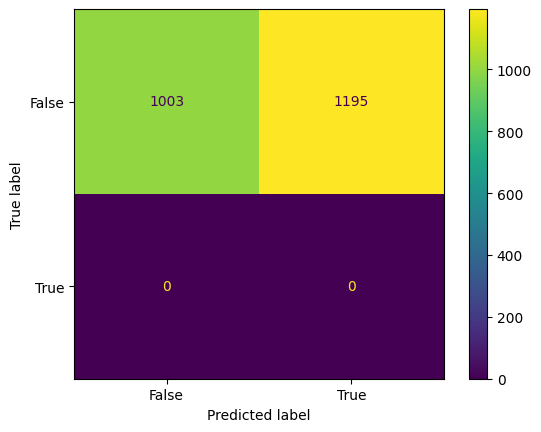

In [ ]:
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, roc_auc_score
import pandas as pd

#Prepare training and test sets
X_train = rare_lasso_dataset.drop(columns=["target"])
y_train = rare_lasso_dataset["target"]
X_test = uncategorised_df_2.drop(columns=["target", "subject_id"])
y_test = uncategorised_df_2["target"]

#Train the CatBoost model
cat = CatBoostClassifier(verbose=0, random_state=42)
cat.fit(X_train, y_train)

#Predict on the uncategorised data
y_pred = cat.predict(X_test)
y_pred_prob = cat.predict_proba(X_test)[:, 1]  # probability for class '1' (rare skin)

#Add predictions to X_test DataFrame
X_test = X_test.copy()  # ensure we don't modify original test
X_test["predicted_label"] = y_pred
X_test["rare_skin_prob"] = y_pred_prob

#Evaluating Metrics
clf_report = classification_report(y_test, y_pred)
print(f"Classification Report : \n{clf_report}")
#calculate AUC of model
auc = metrics.roc_auc_score(y_test, y_pred)
#print AUC score
print('Area Under the Curve',auc)
#printing the confusion matrix
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
print(f"Confusion Matrix : \n{confusion_matrix}")
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

# 5. Optional: Reattach subject_id for tracking
X_test["subject_id"] = uncategorised_df_2["subject_id"].values

In [ ]:
# Filter predicted rare skin disease cases (predicted_label == 1)
uncategorised_predicted_rare_skin = X_test[X_test["predicted_label"] == 1].copy()

# Select necessary columns from uncategorised_df_1
icd_info = uncategorised_df_1[["subject_id", "icd_code", "long_title"]].copy()

# Merge predicted results with ICD info using subject_id
uncategorised_predicted_rare_skin_icd_info = pd.merge(uncategorised_predicted_rare_skin,icd_info,on="subject_id",how="left")

In [ ]:
#Getting the high confidence predictions only
high_confidence_preds = uncategorised_predicted_rare_skin_icd_info[uncategorised_predicted_rare_skin_icd_info["rare_skin_prob"] > 0.90].copy()

In [ ]:
high_confidence_preds.shape

(0, 105)

In [ ]:
high_confidence_preds['icd_code'].value_counts()

,count
icd_code,


In [ ]:
orphanet_unspecified = pd.read_excel("/content/drive/MyDrive/ColabNotebooks/Rare_Diseases_Research/Data/disorders_unspecified.xlsx")

In [ ]:
orphanet_unspecified[orphanet_unspecified['icd_code']=='Q282']

,Orphacode,Disorder_Name,ICD_10_Codes,icd_code,MIMIC_Disorder,Classification,included
189,1053.000,Vein of Galen aneurysmal malformation,Q28.2,Q282,Arteriovenous malformation of cerebral vessels,Uncategorised,True


Introduce this analysis as follows:

Our trained model was applied to previously uncategorized EHR records to identify additional potential cases of rare skin diseases. We selected only those instances with model confidence ≥90%. After matching these records to ICD codes and consulting the Orphanet database, we discovered that many high-confidence predictions correspond to diseases recognized by Orphanet as rare, but do not have a dedicated ICD classification or are not formally categorized as rare skin diseases within traditional nosologies.

Then present a table like:

Rank	ICD Code	Description	Count	Orphanet Match	Skin Involvement
1	M797	Fibromyalgia	124	✔️ Yes	Partial
2	L298	Pruritus, unspecified	101	✔️ Yes	✔️ Likely
3	E282	Androgen insensitivity	89	✔️ Yes	✔️ (Skin phenotype)
...	...	...	...	...	...

Note: While these conditions are recognized in Orphanet as rare diseases, they are not classified as rare skin diseases per ICD or other structured sources.



These findings underscore a critical gap in current classification systems for rare diseases. Our ML-based approach was able to identify high-confidence candidates that are recognized by Orphanet, but are either lacking specific ICD classification or are excluded from structured rare skin disease taxonomies, despite having skin-related phenotypes. This points to a potential application of machine learning in enhancing the identification and characterization of rare diseases beyond existing hierarchical codes.
“Our model is capable of surfacing real rare disease cases that the ICD or structured EHR datasets overlook — despite these conditions being acknowledged by Orphanet and clinically relevant to skin phenotypes.”
This is exactly the kind of insight that justifies the use of ML in rare disease phenotyping and can make your paper stand out.

## 6. Anomaly Detection

In [ ]:
common_skin_lasso_dataset.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3628 entries, 0 to 3627
Data columns (total 102 columns):
 #    Column                                 Non-Null Count  Dtype  
---   ------                                 --------------  -----  
 0    gender                                 3628 non-null   float64
 1    anchor_age                             3628 non-null   float64
 2    anchor_year                            3628 non-null   float64
 3    admission_type                         3628 non-null   float64
 4    admission_location                     3628 non-null   float64
 5    discharge_location                     3628 non-null   float64
 6    insurance                              3628 non-null   float64
 7    language                               3628 non-null   float64
 8    marital_status                         3628 non-null   float64
 9    race                                   3628 non-null   float64
 10   hospital_expire_flag                   3628 non-null   flo

This is the dataset we are not able to differentiate much, so I decided to pursue anomaly detection using hospital resources utilization. Rare skin diseases compared to common skin diseases require more diagnostic workup (more labs, imaging, consultations), are less well understood, leading to longer hospital stays or treatment trial/error. They also trigger more ICU transfers or polypharmacy, especially if misdiagnosed. This means they manifest as burden anomalies. Training only on common skin disease patients makes sense because we are modeling "expected" clinical burden given a known and well-managed diagnosis.

We hypothesize that patients with rare skin diseases diverge from common care patterns due to diagnostic uncertainty, treatment complexity, and comorbid burden. By modeling the clinical resource utilization patterns of common skin disease patients as a normative baseline, we apply anomaly detection to identify patients whose healthcare trajectories exhibit atypical burden profiles. This approach aligns with the broader principle of semi-supervised anomaly detection, where deviations from expected patterns signal potential rare or complex cases.

In [ ]:
# Selecting the clinical burden features
burden_features = [
    'los',                       # Length of stay
    'no_of_transfers',           # Number of transfers between units
    'no_of_distinct_careunits',  # Distinct care units
    'no_of_icu_stays',           # ICU stays
    'count_consults',            # Number of specialty consults
    'unique_lab_types',          # Lab types (diagnostic breadth)
    'frequency_value_lactate',   # High-severity lab
    'unique_medications',        # Medication complexity
    'polypharmacy',              # 5+ concurrent meds
    'time_to_first_lab_hrs',     # Delay to lab testing
]

#Standardising the features
from sklearn.preprocessing import StandardScaler
# Extract and scale the burden features
X_burden = common_skin_lasso_dataset[burden_features].copy()
scaler = StandardScaler()
X_burden_scaled = scaler.fit_transform(X_burden)

#Computing the Mahalanobis Distance using common skin diseases patients only
import numpy as np
from scipy.spatial import distance

# Select only common skin disease patients (target = 0)
X_common = X_burden_scaled[common_skin_lasso_dataset['target'] == 0]

# Compute mean and inverse covariance matrix using only common class
mean_vec = np.mean(X_common, axis=0)
cov_matrix = np.cov(X_common, rowvar=False)
inv_cov_matrix = np.linalg.inv(cov_matrix)

# Compute Mahalanobis distance for ALL patients, using common reference
mahalanobis_scores = [distance.mahalanobis(x, mean_vec, inv_cov_matrix) for x in X_burden_scaled]

# Add scores to full dataset
common_skin_lasso_dataset['burden_anomaly_score'] = mahalanobis_scores

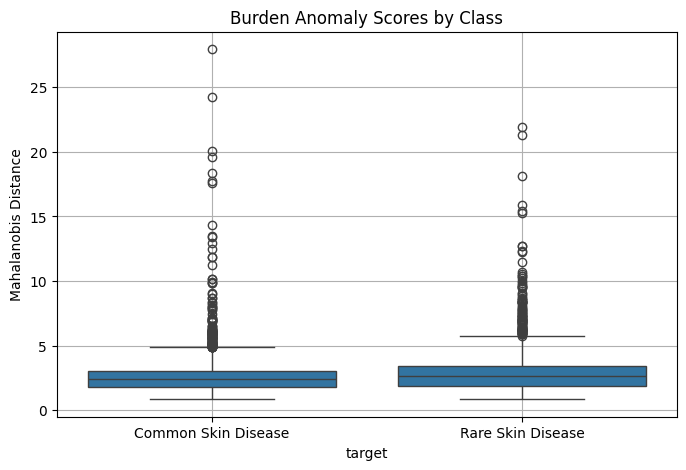

In [ ]:
plt.figure(figsize=(8, 5))
sns.boxplot(x='target', y='burden_anomaly_score', data=common_skin_lasso_dataset)
plt.xticks([0, 1], ['Common Skin Disease', 'Rare Skin Disease'])
plt.title('Burden Anomaly Scores by Class')
plt.ylabel('Mahalanobis Distance')
plt.grid(True)
plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score, average_precision_score

y_true = common_skin_lasso_dataset['target']
y_scores = common_skin_lasso_dataset['burden_anomaly_score']

roc_auc = roc_auc_score(y_true, y_scores)
pr_auc = average_precision_score(y_true, y_scores)

print(f"Burden Anomaly Score ROC AUC: {roc_auc:.3f}")
print(f"Burden Anomaly Score PR AUC: {pr_auc:.3f}")

Burden Anomaly Score ROC AUC: 0.561
Burden Anomaly Score PR AUC: 0.457


Both distributions are similar in median and IQR. Rare skin disease patients tend to have more high-distance outliers (though not drastically). This experiment shows that Mahalanobis distance over clinical burden features does capture some signal, but it's weak. In essence, rare skin disease patients don’t stand out dramatically in terms of overall clinical burden, at least in the feature space being used.

In [ ]:
from sklearn.ensemble import IsolationForest
from sklearn.metrics import roc_auc_score, average_precision_score

# Train on common skin only
X_train = common_skin_lasso_dataset[common_skin_lasso_dataset['target'] == 0].drop(columns=['target','age_group'])
X_all = common_skin_lasso_dataset.drop(columns=['target','age_group'])
y_all = common_skin_lasso_dataset['target']

model = IsolationForest(n_estimators=100, contamination='auto', random_state=42)
model.fit(X_train)

# Get anomaly scores (flip sign: higher = more anomalous)
scores = -model.decision_function(X_all)

# Evaluate
roc_auc = roc_auc_score(y_all, scores)
pr_auc = average_precision_score(y_all, scores)
print("Isolation Forest ROC AUC:", roc_auc)
print("Isolation Forest PR AUC:", pr_auc)

Isolation Forest ROC AUC: 0.5963672731965415
Isolation Forest PR AUC: 0.4927295231670924


### 📉 Anomaly Detection for Rare Skin Disease Identification

Rare diseases often exhibit outlier-like characteristics in clinical data, particularly in terms of resource utilization and diagnostic complexity. Motivated by this, we explored unsupervised anomaly detection techniques to investigate whether rare skin disease patients could be identified as clinical outliers among patients with common skin diseases.

We constructed an anomaly detection setting using a binary-labeled dataset (`common_skin_lasso_dataset`) where the negative class (`label = 0`) comprised patients with common skin diseases and the positive class (`label = 1`) comprised patients with rare skin diseases. The goal was to train an unsupervised model solely on common skin disease cases and evaluate whether it would assign high anomaly scores to rare skin disease cases.

We applied the **Isolation Forest** algorithm, a widely used anomaly detection technique that isolates anomalies via recursive partitioning. The model was trained on the negative class (`label = 0`) only. After training, we generated anomaly scores for the entire dataset, including rare disease patients.

To evaluate the model’s ability to distinguish rare from common cases, we used **ROC AUC** and **Precision-Recall AUC (PR AUC)**. The performance was modest:

* **ROC AUC**: 0.596
* **PR AUC**: 0.493

These scores suggest that while there may be some weak signal differentiating rare skin diseases from common ones in terms of hospital resource utilization, it is not strong enough for reliable unsupervised detection. We hypothesize that:

1. **Rare and common skin diseases may have overlapping patterns** in lab results, medications, and hospital interactions, making them difficult to distinguish purely via outlier detection.
2. **Feature representation may not capture latent complexities** of rare conditions—structured tabular features alone might miss nuanced diagnostic, progression, or treatment cues.
3. **Label imbalance and heterogeneity** among rare cases likely dilute any consistent anomaly signature.

## 7. Contrastive Learning

#### 7.1 Common Skin Diseases vs Rare Skin Diseases

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Prepare features
df = common_skin_lasso_dataset.drop(columns=['target', 'age_group'])
labels = common_skin_lasso_dataset['target'].values  # save for evaluation

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df)

# Create positive pairs via augmentation (add small noise or mask some features)
def augment(x, noise_std=0.01, mask_prob=0.1):
    x_aug = x.copy()
    noise = np.random.normal(0, noise_std, size=x.shape)
    mask = np.random.rand(*x.shape) < mask_prob
    x_aug[mask] = 0  # mask
    x_aug += noise
    return x_aug

# Create contrastive dataset
X1, X2 = [], []
for x in X_scaled:
    X1.append(augment(x))
    X2.append(augment(x))

X1, X2 = np.array(X1), np.array(X2)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dataset
tensor_x1 = torch.tensor(X1, dtype=torch.float32)
tensor_x2 = torch.tensor(X2, dtype=torch.float32)
contrastive_dataset = TensorDataset(tensor_x1, tensor_x2)
loader = DataLoader(contrastive_dataset, batch_size=128, shuffle=True)

# Simple encoder
class Encoder(nn.Module):
    def __init__(self, input_dim, embed_dim=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, embed_dim)
        )

    def forward(self, x):
        return F.normalize(self.net(x), dim=1)  # normalize to unit sphere

encoder = Encoder(input_dim=X1.shape[1]).to(device)
optimizer = torch.optim.Adam(encoder.parameters(), lr=1e-3)

In [ ]:
def nt_xent_loss(z1, z2, temperature=0.5):
    z1 = F.normalize(z1, dim=1)
    z2 = F.normalize(z2, dim=1)
    representations = torch.cat([z1, z2], dim=0)
    similarity_matrix = F.cosine_similarity(representations.unsqueeze(1), representations.unsqueeze(0), dim=2)

    batch_size = z1.shape[0]
    labels = torch.arange(batch_size).to(device)
    labels = torch.cat([labels, labels], dim=0)

    mask = torch.eye(batch_size * 2, dtype=torch.bool).to(device)
    similarity_matrix = similarity_matrix[~mask].view(2 * batch_size, -1)

    positives = torch.exp(torch.sum(z1 * z2, dim=-1) / temperature)
    positives = torch.cat([positives, positives], dim=0)

    denominator = torch.sum(torch.exp(similarity_matrix / temperature), dim=1)

    loss = -torch.log(positives / denominator).mean()
    return loss

In [ ]:
# Training loop
epochs = 20
encoder.train()
for epoch in range(epochs):
    total_loss = 0
    for xb1, xb2 in loader:
        xb1, xb2 = xb1.to(device), xb2.to(device)
        z1, z2 = encoder(xb1), encoder(xb2)
        loss = nt_xent_loss(z1, z2)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}: Loss = {total_loss:.4f}")

Epoch 1: Loss = 114.2757
Epoch 2: Loss = 110.8747
Epoch 3: Loss = 109.9785
Epoch 4: Loss = 109.5352
Epoch 5: Loss = 109.1020
Epoch 6: Loss = 108.8621
Epoch 7: Loss = 108.7150
Epoch 8: Loss = 108.5929
Epoch 9: Loss = 108.3464
Epoch 10: Loss = 108.2708
Epoch 11: Loss = 108.1452
Epoch 12: Loss = 108.1476
Epoch 13: Loss = 108.0718
Epoch 14: Loss = 107.9372
Epoch 15: Loss = 107.8754
Epoch 16: Loss = 107.7596
Epoch 17: Loss = 107.7489
Epoch 18: Loss = 107.7166
Epoch 19: Loss = 107.7453
Epoch 20: Loss = 107.6218


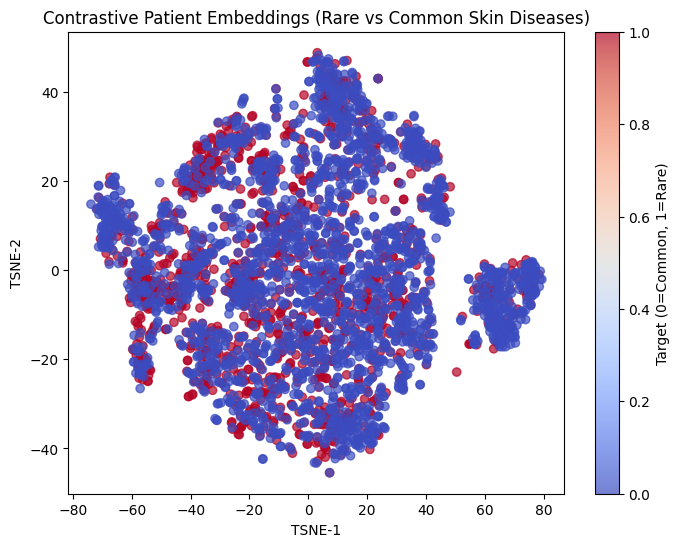

In [ ]:
# Get final embeddings for original data
encoder.eval()
with torch.no_grad():
    embeddings = encoder(torch.tensor(X_scaled, dtype=torch.float32).to(device)).cpu().numpy()

# t-SNE or UMAP
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
emb_2d = tsne.fit_transform(embeddings)

plt.figure(figsize=(8,6))
plt.scatter(emb_2d[:,0], emb_2d[:,1], c=labels, cmap='coolwarm', alpha=0.7)
plt.title("Contrastive Patient Embeddings (Rare vs Common Skin Diseases)")
plt.xlabel("TSNE-1")
plt.ylabel("TSNE-2")
plt.colorbar(label='Target (0=Common, 1=Rare)')
plt.show()

We used contrastive learning to generate low-dimensional embeddings of patients with rare and common skin diseases. A t-SNE visualization (Figure X) reveals substantial overlap between the two classes, with rare (red) and common (blue) patients dispersed across the embedding space. This suggests that structured EHR data may lack strong discriminative signals to clearly separate rare and common skin conditions in latent space. Consequently, downstream classifiers may face difficulty distinguishing between the two groups using current feature representations.

#### 7.2 Rare Diseases vs Rare Skin Diseases

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Prepare dataset
df_rare = rare_lasso_dataset.drop(columns=['target'])
labels_rare = rare_lasso_dataset['target'].values  # Save for later visualization

# Scale features
scaler = StandardScaler()
X_scaled_rare = scaler.fit_transform(df_rare)

# Augmentation function
def augment(x, noise_std=0.01, mask_prob=0.1):
    x_aug = x.copy()
    noise = np.random.normal(0, noise_std, size=x.shape)
    mask = np.random.rand(*x.shape) < mask_prob
    x_aug[mask] = 0  # mask some features
    x_aug += noise
    return x_aug

# Create positive pairs by augmenting same record
X1_rare, X2_rare = [], []
for x in X_scaled_rare:
    X1_rare.append(augment(x))
    X2_rare.append(augment(x))

X1_rare = np.array(X1_rare)
X2_rare = np.array(X2_rare)


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Contrastive encoder
class Encoder(nn.Module):
    def __init__(self, input_dim, embed_dim=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, embed_dim)
        )

    def forward(self, x):
        return F.normalize(self.net(x), dim=1)

encoder_rare = Encoder(input_dim=X1_rare.shape[1]).to(device)
optimizer_rare = torch.optim.Adam(encoder_rare.parameters(), lr=1e-3)

In [ ]:
def nt_xent_loss(z1, z2, temperature=0.5):
    z1 = F.normalize(z1, dim=1)
    z2 = F.normalize(z2, dim=1)
    representations = torch.cat([z1, z2], dim=0)
    similarity_matrix = F.cosine_similarity(representations.unsqueeze(1), representations.unsqueeze(0), dim=2)

    batch_size = z1.shape[0]
    labels = torch.arange(batch_size).to(device)
    labels = torch.cat([labels, labels], dim=0)

    mask = torch.eye(batch_size * 2, dtype=torch.bool).to(device)
    similarity_matrix = similarity_matrix[~mask].view(2 * batch_size, -1)

    positives = torch.exp(torch.sum(z1 * z2, dim=-1) / temperature)
    positives = torch.cat([positives, positives], dim=0)

    denominator = torch.sum(torch.exp(similarity_matrix / temperature), dim=1)
    loss = -torch.log(positives / denominator).mean()
    return loss

In [ ]:
# Build DataLoader
tensor_x1 = torch.tensor(X1_rare, dtype=torch.float32)
tensor_x2 = torch.tensor(X2_rare, dtype=torch.float32)
rare_dataset = TensorDataset(tensor_x1, tensor_x2)
rare_loader = DataLoader(rare_dataset, batch_size=128, shuffle=True)

# Train
epochs = 20
encoder_rare.train()
for epoch in range(epochs):
    total_loss = 0
    for xb1, xb2 in rare_loader:
        xb1, xb2 = xb1.to(device), xb2.to(device)
        z1, z2 = encoder_rare(xb1), encoder_rare(xb2)
        loss = nt_xent_loss(z1, z2)

        optimizer_rare.zero_grad()
        loss.backward()
        optimizer_rare.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}: Loss = {total_loss:.4f}")

Epoch 1: Loss = 12.3155
Epoch 2: Loss = 11.2634
Epoch 3: Loss = 10.9011
Epoch 4: Loss = 10.8634
Epoch 5: Loss = 10.8617
Epoch 6: Loss = 10.7694
Epoch 7: Loss = 10.6944
Epoch 8: Loss = 10.6190
Epoch 9: Loss = 10.6030
Epoch 10: Loss = 10.5385
Epoch 11: Loss = 10.5158
Epoch 12: Loss = 10.4943
Epoch 13: Loss = 10.4998
Epoch 14: Loss = 10.4701
Epoch 15: Loss = 10.4500
Epoch 16: Loss = 10.4337
Epoch 17: Loss = 10.4441
Epoch 18: Loss = 10.4030
Epoch 19: Loss = 10.3976
Epoch 20: Loss = 10.3842


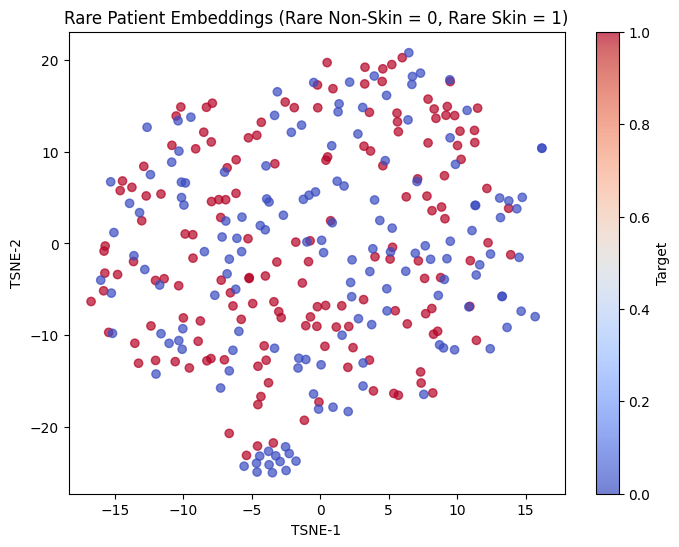

In [ ]:
# Get learned embeddings
encoder_rare.eval()
with torch.no_grad():
    embeddings_rare = encoder_rare(torch.tensor(X_scaled_rare, dtype=torch.float32).to(device)).cpu().numpy()

# Visualize via t-SNE
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
emb_2d_rare = tsne.fit_transform(embeddings_rare)

plt.figure(figsize=(8,6))
plt.scatter(emb_2d_rare[:,0], emb_2d_rare[:,1], c=labels_rare, cmap='coolwarm', alpha=0.7)
plt.title("Rare Patient Embeddings (Rare Non-Skin = 0, Rare Skin = 1)")
plt.xlabel("TSNE-1")
plt.ylabel("TSNE-2")
plt.colorbar(label='Target')
plt.show()

#### 7.3 Combination of Diseases vs Rare Skin Diseases

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Prepare dataset
df_combo = combo_lasso_dataset.drop(columns=['target'])
labels_combo = combo_lasso_dataset['target'].values  # Save for t-SNE coloring later

# Scale features
scaler = StandardScaler()
X_scaled_combo = scaler.fit_transform(df_combo)

def augment(x, noise_std=0.01, mask_prob=0.1):
    x_aug = x.copy()
    noise = np.random.normal(0, noise_std, size=x.shape)
    mask = np.random.rand(*x.shape) < mask_prob
    x_aug[mask] = 0  # mask some features
    x_aug += noise
    return x_aug

# Create positive pairs (augmented versions of same record)
X1_combo, X2_combo = [], []
for x in X_scaled_combo:
    X1_combo.append(augment(x))
    X2_combo.append(augment(x))

X1_combo = np.array(X1_combo)
X2_combo = np.array(X2_combo)


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class Encoder(nn.Module):
    def __init__(self, input_dim, embed_dim=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, embed_dim)
        )

    def forward(self, x):
        return F.normalize(self.net(x), dim=1)

encoder_combo = Encoder(input_dim=X1_combo.shape[1]).to(device)
optimizer_combo = torch.optim.Adam(encoder_combo.parameters(), lr=1e-3)

In [ ]:
def nt_xent_loss(z1, z2, temperature=0.5):
    z1 = F.normalize(z1, dim=1)
    z2 = F.normalize(z2, dim=1)
    representations = torch.cat([z1, z2], dim=0)
    similarity_matrix = F.cosine_similarity(representations.unsqueeze(1), representations.unsqueeze(0), dim=2)

    batch_size = z1.shape[0]
    labels = torch.arange(batch_size).to(device)
    labels = torch.cat([labels, labels], dim=0)

    mask = torch.eye(batch_size * 2, dtype=torch.bool).to(device)
    similarity_matrix = similarity_matrix[~mask].view(2 * batch_size, -1)

    positives = torch.exp(torch.sum(z1 * z2, dim=-1) / temperature)
    positives = torch.cat([positives, positives], dim=0)

    denominator = torch.sum(torch.exp(similarity_matrix / temperature), dim=1)
    loss = -torch.log(positives / denominator).mean()
    return loss

In [ ]:
# DataLoader
tensor_x1 = torch.tensor(X1_combo, dtype=torch.float32)
tensor_x2 = torch.tensor(X2_combo, dtype=torch.float32)
combo_dataset = TensorDataset(tensor_x1, tensor_x2)
combo_loader = DataLoader(combo_dataset, batch_size=128, shuffle=True)

# Training loop
epochs = 20
encoder_combo.train()
for epoch in range(epochs):
    total_loss = 0
    for xb1, xb2 in combo_loader:
        xb1, xb2 = xb1.to(device), xb2.to(device)
        z1, z2 = encoder_combo(xb1), encoder_combo(xb2)
        loss = nt_xent_loss(z1, z2)

        optimizer_combo.zero_grad()
        loss.backward()
        optimizer_combo.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}: Loss = {total_loss:.4f}")

Epoch 1: Loss = 110.6290
Epoch 2: Loss = 107.0577
Epoch 3: Loss = 106.4102
Epoch 4: Loss = 105.9449
Epoch 5: Loss = 105.5620
Epoch 6: Loss = 105.3517
Epoch 7: Loss = 105.1545
Epoch 8: Loss = 105.0234
Epoch 9: Loss = 104.8633
Epoch 10: Loss = 104.7121
Epoch 11: Loss = 104.6845
Epoch 12: Loss = 104.5749
Epoch 13: Loss = 104.4949
Epoch 14: Loss = 104.4415
Epoch 15: Loss = 104.3638
Epoch 16: Loss = 104.3055
Epoch 17: Loss = 104.2318
Epoch 18: Loss = 104.2621
Epoch 19: Loss = 104.1375
Epoch 20: Loss = 104.0789


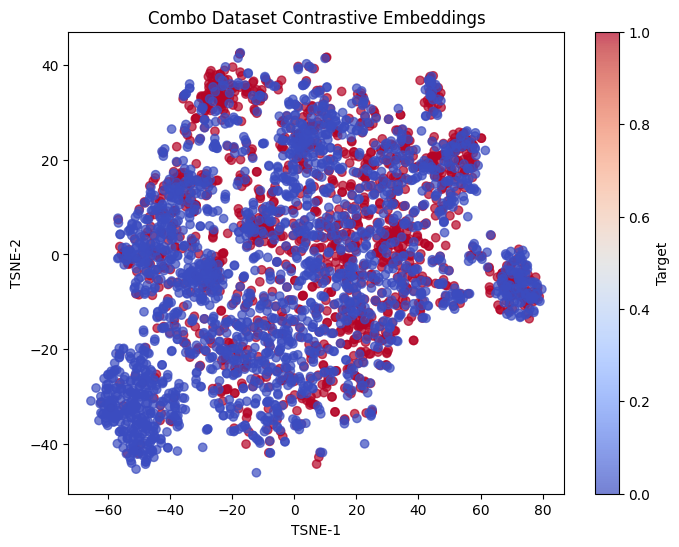

In [ ]:
# Extract embeddings
encoder_combo.eval()
with torch.no_grad():
    embeddings_combo = encoder_combo(torch.tensor(X_scaled_combo, dtype=torch.float32).to(device)).cpu().numpy()

# t-SNE
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
emb_2d_combo = tsne.fit_transform(embeddings_combo)

plt.figure(figsize=(8,6))
plt.scatter(emb_2d_combo[:,0], emb_2d_combo[:,1], c=labels_combo, cmap='coolwarm', alpha=0.7)
plt.title("Combo Dataset Contrastive Embeddings")
plt.xlabel("TSNE-1")
plt.ylabel("TSNE-2")
plt.colorbar(label='Target')
plt.show()